In [1]:
!pip install torch

In [2]:
import torch
import torch.nn.functional as F

class DynamicSparseAttention(torch.nn.Module):
    def __init__(self, dim, base_tau=1.0, min_tau=0.3):
        super().__init__()
        self.scale = dim ** -0.5
        self.base_tau = base_tau
        self.min_tau = min_tau

    def forward(self, q, k, v):
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        complexity = attn_scores.var(dim=-1, keepdim=True)
        tau = self.base_tau / (1 + complexity)
        tau = tau.clamp(min=self.min_tau)
        attn = F.softmax(attn_scores / tau, dim=-1)
        return attn @ v, attn, tau

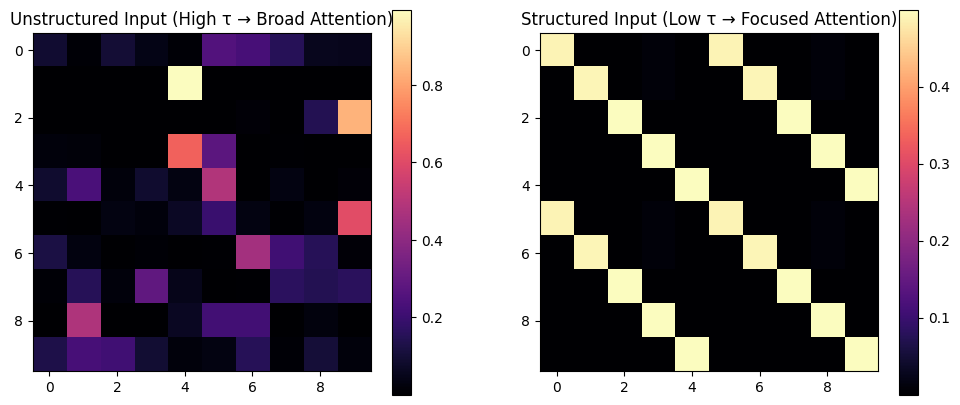

τ (unstructured): 0.47822004556655884
τ (structured): 0.33143728971481323


In [3]:
import matplotlib.pyplot as plt

# 构造两种输入：1) 杂乱 2) 有结构
q1 = torch.randn(1, 10, 16)
k1 = torch.randn(1, 10, 16)
v1 = torch.randn(1, 10, 16)

# structured = 第二段是第一段的重复（产生强模式）
base = torch.randn(1, 5, 16)
q2 = torch.cat([base, base], dim=1)
k2 = torch.cat([base, base], dim=1)
v2 = torch.cat([base, base], dim=1)

attn = DynamicSparseAttention(dim=16)

_, weights1, tau1 = attn(q1, k1, v1)
_, weights2, tau2 = attn(q2, k2, v2)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Unstructured Input (High τ → Broad Attention)")
plt.imshow(weights1[0].detach().numpy(), cmap='magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Structured Input (Low τ → Focused Attention)")
plt.imshow(weights2[0].detach().numpy(), cmap='magma')
plt.colorbar()

plt.show()

print("τ (unstructured):", tau1.mean().item())
print("τ (structured):", tau2.mean().item())